In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

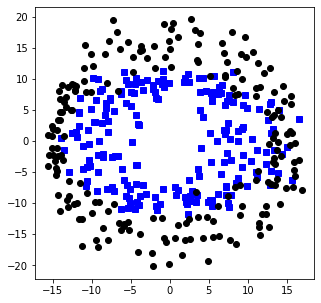

In [5]:
nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

a = [r1*np.cos(th) + np.random.randn(nPerClust)*3,
    r1*np.sin(th) + np.random.randn(nPerClust)]
b = [r2*np.cos(th) + np.random.randn(nPerClust),
    r2*np.sin(th) + np.random.randn(nPerClust)*3]

labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

data_np = np.hstack((a,b)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.show();

In [6]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=.2)

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

In [9]:
batchsize = 16
train_loader =  DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [20]:
class theModelClass(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()
        
        self.input = nn.Linear(2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128,1)
        
        self.dr = dropoutRate

    
    def forward(self,x):
        
        x = F.relu(self.input(x))
        
        x = F.dropout(x,p=self.dr,training=self.training)
        
        x = F.relu(self.hidden(x))
        
        x = F.dropout(x,p=self.dr,training=self.training)
        
        x = self.output(x)
        
        return x

In [21]:
tempnet = theModelClass(.25)
tempdata = torch.randn((10,2))
yHat = tempnet(tempdata)
yHat

tensor([[0.2676],
        [0.4494],
        [0.1108],
        [0.1437],
        [0.2822],
        [0.2782],
        [0.4819],
        [0.4463],
        [0.2344],
        [0.4715]], grad_fn=<AddmmBackward0>)

In [25]:
def createANewModel(dropoutRate):
    
    ANNQC = theModelClass(dropoutRate)
    
    lossfun = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.SGD(ANNQC.parameters(),lr=.002)
    
    return ANNQC,lossfun,optimizer

In [27]:
numepochs = 1000

def trainTheModel(ANNQC,lossfun,optimizer):
    
    trainAcc = []
    testAcc = []
    
    for epochi in range(numepochs):
        
        ANNQC.train()
        batchAcc = []
        
        for X,y in train_loader:
            
            yHat = ANNQC(X)
            loss = lossfun(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
            
        trainAcc.append(np.mean(batchAcc))
        yHat = ANNQC(X)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
    return trainAcc,testAcc

In [28]:
dropoutrate = .0
ANNQC,lossfun,optimizer = createANewModel(dropoutrate)
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

In [30]:
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

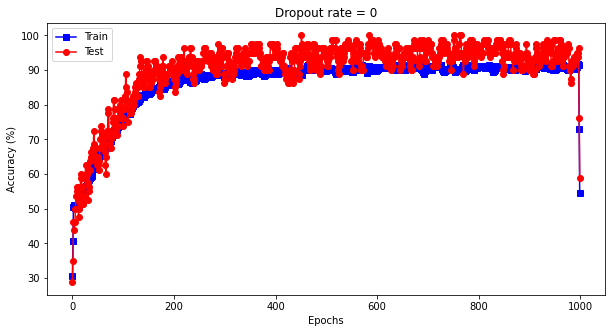

In [31]:
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

In [36]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

In [37]:
for di in range(len(dropoutRates)):
    ANNQC,lossfun,optimizer = createANewModel(dropoutRates[di])
    trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)
    
    results[di,0] = np.mean(trainAcc[-100:])
    results[di,0] = np.mean(testAcc[-100:])

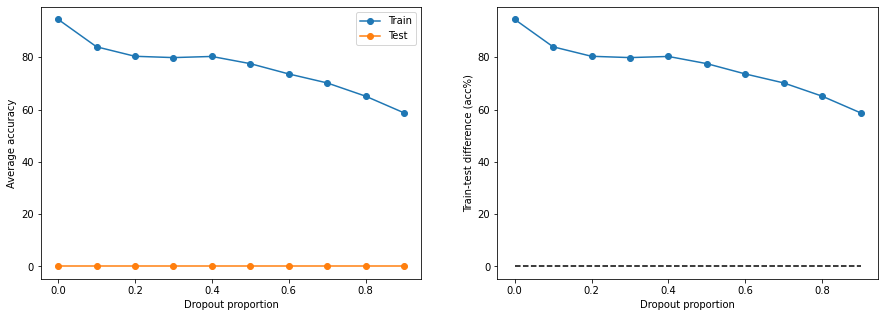

In [38]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()